In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scienceplots
import seaborn as sns
import matplotlib.animation as animation
from scipy.fft import fft, rfft, fftfreq, rfftfreq
from scipy import signal

def get_pos(N, N_e=8):

    pos     = {}
    node    = N_e

    for y in range(N):
        for x in range(N):

            pos[node]   = (x,y)
            node        += 1

    pos[0] = (-1,-1)
    if N % 2 != 0:
        pos[1] = (int(N/2),-1)
    else:
        pos[1] = (int(N/2)-1,-1)
    pos[2] = (N,-1)
    if N % 2 != 0:
        pos[3] = (-1,int(N/2))
    else:
        pos[3] = (-1,int(N/2)-1)
    pos[4] = (-1,N)
    pos[5] = (N,int(N/2))
    pos[6] = (int(N/2),N)
    pos[7] = (N,N)

    return pos

def min_max(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

cmeter      = 1/2.54
single_col  = 8.6
blue_color  = '#4477AA'
red_color   = '#EE6677'

N_voltages  = 5000
step_size   = 1e-8
time_steps  = np.cumsum(np.repeat(step_size, N_voltages))
time_steps  = time_steps[1:]

### Noise

In [187]:
def load_noise_data(N_NP, n_runs=10, m_inners=5):

    noise_data  = {}
    n           = 0

    for i in range(0,n_runs):

        for j in range(m_inners):

            df_tmp          = pd.read_csv(f"data/noise/Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_{i}_{j}.csv")
            df_tmp          = df_tmp.drop(columns=['Eq_Jumps', 'Error'])
            noise_data[n]   = df_tmp
            n               += 1

    return noise_data

data = {N_NP : load_noise_data(N_NP) for N_NP in [3,5,7,9]}

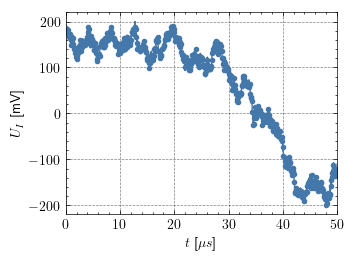

In [152]:
n       = 1
N_NP    = 5

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, data[N_NP][n]['E0']*1000, '.-', color=blue_color, markevery=10)
    # ax1.plot(time_steps*10**6, noise_data[10]['E0'], '.-', color=blue_color, markevery=10)
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$U_I$ [mV]')
    ax1.set_xlim(0,50)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    # fig.savefig(f"plots/noise/N={N_NP}_input_signal_{n}.svg", bbox_inches='tight', transparent=True)
    # fig.savefig(f"plots/noise/N={N_NP}_input_signal_{n}.pdf", bbox_inches='tight', transparent=False)

plt.show()

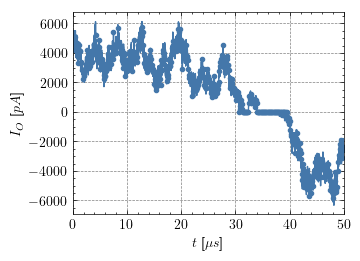

In [153]:
n       = 1
N_NP    = 5

with plt.style.context(['science', 'bright', 'grid']):
    
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.plot(time_steps*10**6, data[N_NP][n]['Current'], '.-', color=blue_color, markevery=10)
    # ax1.plot(time_steps*10**6, noise_data[10]['E0'], '.-', color=blue_color, markevery=10)
    # ax1.fill_between(time_steps*10**6, df['Current']-df['Error'], df['Current']+df['Error'], color=red_color, alpha=.6)
    ax1.set_xlabel('$t$ [$\mu s$]')
    ax1.set_ylabel('$I_O$ [$pA$]')
    ax1.set_xlim(0,50)
    # ax1.legend(loc='upper left')
    # ax1.set_ylim(-1,1)

    # fig.savefig(f"plots/noise/N={N_NP}_output_signal_{n}.svg", bbox_inches='tight', transparent=True)
    # fig.savefig(f"plots/noise/N={N_NP}_output_signal_{n}.pdf", bbox_inches='tight', transparent=False)

plt.show()

In [220]:
def cross_corr(x,y,norm=False):
    
    if norm:
        xn  = (x - np.mean(x))/(np.std(x)*len(x))
        yn  = (y - np.mean(y))/(np.std(y))
    else:
        xn  = x
        yn  = y

    c   = np.correlate(xn, yn, 'full')

    return c

def return_avg_cross_corr(dic, x_label='E0', y_label='Current'):

    c_df = pd.DataFrame()

    for key, df in dic.items():
            
        test_x      = df[x_label].values
        test_y      = df[y_label].values
        c_val       = cross_corr(test_x, test_y, False)
        c_df[key]   = c_val[len(c_val)//2:]
        
    t_vals  = time_steps[:len(c_df)]*10**6
    c_means = c_df.mean(axis=1)  
    c_std   = c_df.std(axis=1)

    return t_vals, c_means, c_std

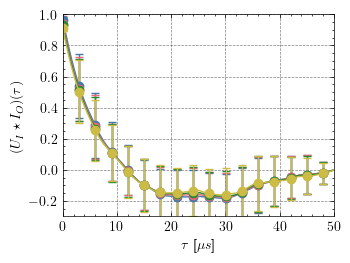

In [196]:
with plt.style.context(['science', 'bright','grid']):

    fig = plt.figure()
    ax  = fig.add_subplot()

    for key in data:
        
        t_vals, c_means, c_std = return_avg_cross_corr(data[key])
        ax.errorbar(t_vals, c_means, c_std, markevery=300, errorevery=300, capsize=3, marker='o')

    ax.set_xlabel("$\\tau$ [$\mu s$]")
    ax.set_xlim(0,50)
    ax.set_ylim(-0.3,1)
    ax.set_ylabel("$(U_I \star I_O)(\\tau)$")

plt.show()

# States

In [166]:
states      = {}
ele_charge  = 1.60217663e-19
n           = 0
for i in range(0,10):
    for j in range(5):

        df_tmp      = pd.read_csv(f"data/noise/mean_state_Nx={N_NP}_Ny={N_NP}_Nz=1_Ne=2_{i}_{j}.csv")
        states[n]   = df_tmp
        n           += 1

In [232]:
def my_MC(x, y, tau):

    x_rolled    = np.roll(x, tau)
    a           = np.sum(((x_rolled - np.mean(x)) * (y - np.mean(y)))**2)
    b           = np.sum((x_rolled - np.mean(x))**2)
    c           = np.sum((y - np.mean(y))**2)

    return a / (b*c)

In [240]:
n_th    = 1
i_np    = 0
u_vals  = data[N_NP][n_th]['E0'].values
s_vals  = states[n_th].iloc[:,0]

mc_np0 = [my_MC(u_vals, s_vals, lag) for lag in range(100)]

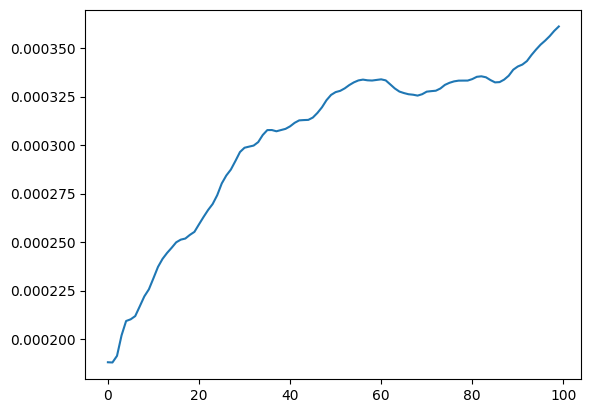

In [241]:
plt.plot(mc_np0)
plt.show()

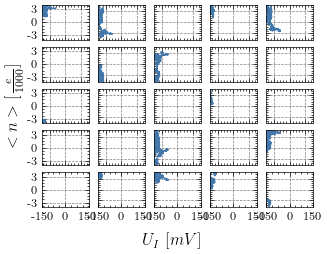

In [206]:
ele_charge  = 1.60217663e-19
plot_order  = [20,21,22,23,24,15,16,17,18,19,10,11,12,13,14,5,6,7,8,9,0,1,2,3,4]
n_th        = 0
u_vals      = data[N_NP][n_th]

with plt.style.context(['science', 'bright','grid']):

    fig = plt.figure()

    for n,i in enumerate(plot_order):
        
        ax  = fig.add_subplot(5,5,n+1)
        ax.plot(u_vals.loc[4000:5000,'E0']*1000, 1000*states[n_th].iloc[4000:5000,i])
        ax.set_xlim(-150,150)
        ax.set_ylim(-4,4)
        
        ax.set_xticklabels('')
        ax.set_yticklabels('')

        if n > 19:
            ax.set_xticks([-150,0,150])
            ax.set_xticklabels([-150,0,150], fontsize='small')

        if n % 5 == 0:
            ax.set_yticks([-3,0,3])
            ax.set_yticklabels([-3,0,3], fontsize='small')

    fig.supxlabel('$U_I$ [$mV$]', y=-0.05)
    fig.supylabel('$<n>$ [$\\frac{e}{1000}$]')

    # fig.savefig(f"plots/states/"+f_str+f"N_{N_NP}_n_vs_U_grid.svg", bbox_inches='tight', transparent=True)
    # fig.savefig(f"plots/states/"+f_str+f"N_{N_NP}_n_vs_U_grid.pdf", bbox_inches='tight', transparent=False)

    plt.show()

In [ ]:
G   = nx.DiGraph()
G.add_nodes_from([i for i in range(49+8)])
G.add_edges_from([eval(i) for i in pd.read_csv(f"data/periodic/net_currents_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv").columns])
pos             = get_pos(7)
node_color      = np.repeat(blue_color, 49+8)
node_color[0:8] = None
node_labels     = {i:'' for i in range(49+8)}
node_labels[0]  = '$I$'
node_labels[2]  = '$C$'
node_labels[4]  = '$C$'
node_labels[7]  = '$O$'
node_labels[1]  = '$C$'
node_labels[3]  = '$C$'
node_labels[5]  = '$C$'
node_labels[6]  = '$C$'

In [ ]:
states = pd.read_csv(f"data/periodic/mean_state_Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
states

In [ ]:
s_vals = states.abs()
s_vals = s_vals/np.max(s_vals.max())
s_logs = np.log(s_vals)
s_logs = s_logs - np.min(s_logs.min())
s_logs

In [ ]:
s_flat  = states.values.flatten()
s_flat  = (s_flat - np.min(s_flat))/(np.max(s_flat) - np.min(s_flat))
s_flat  = s_flat.reshape(-1,49)
s_flat

In [51]:
with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    def update(row):
        
        ax.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 500*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax, node_color=node_colors, arrows=False, labels=node_labels, font_size=8)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.axis('off')


    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=200, repeat_delay=1000, repeat=True)
    ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.


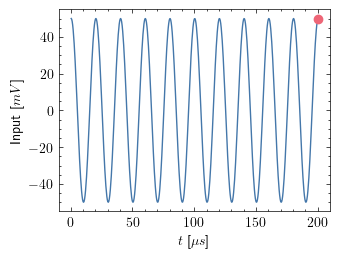

In [55]:
raw_data    = pd.read_csv(f"data/periodic/Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    ax  = fig.add_subplot()

    def update(step):
        ax.clear()
        ax.plot(t_vals, in_vals)
        ax.plot(t_vals[step], in_vals[step], 'o')
        ax.set_xlabel('$t$ [$\mu s$]')
        ax.set_ylabel('Input [$mV$]')
        ax.set_xlim(0,200)
        ax.set_ylim(-50,50)
        
    ani = animation.FuncAnimation(fig, update, frames=len(states), interval=200, repeat_delay=1000, repeat=True)
    ani.save("test2.gif")

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


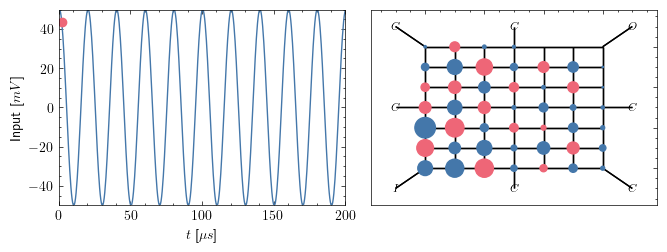

In [61]:
raw_data    = pd.read_csv(f"data/periodic/Nx=7_Ny=7_Nz=1_Ne=8_0_0.csv")
in_vals     = 1000*raw_data['E0'].values
t_vals      = time_steps*10**6

with plt.style.context(['science','bright']):
    
    fig = plt.figure()
    fig.set_figwidth(2*single_col*cmeter)
    # fig.set_figheight(single_col*cmeter)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    def update(row):

        ax1.clear()
        ax1.plot(t_vals, in_vals)
        ax1.plot(t_vals[row], in_vals[row], 'o')
        ax1.set_xlabel('$t$ [$\mu s$]')
        ax1.set_ylabel('Input [$mV$]')
        ax1.set_xlim(0,200)
        ax1.set_ylim(-50,50)

        ax2.clear()

        sizes       = np.repeat(0,49+8)
        s_vals      = states.iloc[row].values
        sizes[8:]   = 500*np.abs(s_vals)

        node_colors = np.repeat(blue_color, 49+8)
        node_colors[8:][s_vals < 0] = red_color

        nx.draw_networkx(G, pos=pos, node_size=sizes, ax=ax2, node_color=node_colors, arrows=False, labels=node_labels, font_size=8)
        ax.set_title(f'$t = {np.round((10**6)*time_steps[row],2)}$ $\mu s$')
        plt.tight_layout()
        # plt.axis('off')
        
    ani = animation.FuncAnimation(fig, update, frames=5, interval=200, repeat_delay=1000, repeat=True)
    ani.save("test.gif")

plt.show()